<center> <h2><b>Machine Learning for Healthcare, Project 1: Time-Series</b></h2> </center>
<h3><b>Intensive Care Time Series Modeling for Mortality Predictions on 
the Physionet 2012 Challenge Dataset </b></h3>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic
from sklearn.svm import SVR
from sklearn.ensemble import IsolationForest, StackingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score

### **1. Data Processing and Exploration (5 Pts)**
#### Q1.1: Data Transformation (1 Pts) 

In [ ]:
def parse_data(dataset):
    """
    Parses the data from the given dataset directory and saves it as a parquet file.

    Parameters:
    dataset (str): The path to the dataset directory.

    Returns:
    None
    """
    filename = dataset[5:] + '.parquet'

    # If the file already exists, delete it and create a new one
    if os.path.exists(filename):
        os.remove(filename)

    # Read and compile all files in the directory
    txt_all = []
    for f in os.listdir(dataset):
        with open(os.path.join(dataset, f), 'r') as fp:
            txt = fp.readlines()

        # Get recordid to add as a column
        recordid = txt[1].rstrip('\n').split(',')[-1]
        txt = [t.rstrip('\n').split(',') + [int(recordid)] for t in txt]
        txt_all.extend(txt[1:])

    # Create DataFrame
    df = pd.DataFrame(txt_all, columns=['time', 'parameter', 'value', 'recordid'])
    df = df[df.parameter != 'RecordID']

    # Convert 'time' to hours and minutes and then to total minutes
    def time_to_minutes(time_str):
        hours, minutes = map(int, time_str.split(':'))
        return hours * 60 + minutes

    df['time_minutes'] = df['time'].apply(time_to_minutes)

    # Round up to the nearest hour
    df['time'] = ((df['time_minutes'] + 59) // 60).clip(upper=48)

    # Keep the most recent value by sorting and dropping duplicates
    df.sort_values(by=['recordid', 'time', 'time_minutes'], ascending=[True, True, False], inplace=True)
    df.drop_duplicates(subset=['recordid', 'time', 'parameter'], keep='first', inplace=True)

    # Pivot the DataFrame
    df_pivot = df.pivot_table(index=['recordid', 'time'], columns='parameter', values='value', aggfunc='first').reset_index()

    # Ensure all patients have 49 rows (0 to 48 hours)
    all_hours = pd.DataFrame({'time': range(49)})

    patients = df['recordid'].unique()
    patient_hours = pd.MultiIndex.from_product([patients, all_hours['time']], names=['recordid', 'time'])

    # Reindex to include all patient-hour combinations
    final_df = df_pivot.set_index(['recordid', 'time']).reindex(patient_hours).reset_index()

    # Convert time column into timesteps
    final_df['time'] = final_df['time'].apply(lambda x: f'{x:02}:00')

    static_columns = ["Age", "Gender", "Height", "ICUType", "Weight"]

    # Remove -1 values and propagate the static values to all the rows
    for col in static_columns:
        final_df[col] = final_df[col].astype(float).replace(-1, np.nan)
        final_df[col] = final_df.groupby('recordid')[col].transform(lambda x: x.ffill().bfill())
    
    for col in final_df.columns:
        try:
            final_df[col] = pd.to_numeric(final_df[col], errors='raise')
            # If all values are integers, convert to int
            if final_df[col].apply(float.is_integer).all():
                final_df[col] = final_df[col].astype(int)
        except:
            pass  # Keep as is if conversion fails

    # Fill None missing values with NaN
    final_df = final_df.fillna(value=np.nan)

    final_df.to_parquet(filename, index=False)

def extract_labels(outcome):
    """
    Extracts the labels from the given outcome file and saves it as a parquet file.

    Parameters:
    outcome (str): The path to the outcome file.

    Returns:
    None
    """
    filename = outcome[5:-4].lower() + '.parquet'

    # If the file already exists, delete it and create a new one
    if os.path.exists(filename):
        os.remove(filename)

    with open(outcome, 'r') as fp:
        txt = fp.readlines()
    
    labels = []
    for line in txt[1:]:  # Skip header
        parts = line.strip().split(',')
        recordid = int(parts[0])
        in_hospital_death = int(parts[-1])
        labels.append((recordid, in_hospital_death))

    labels_df = pd.DataFrame(labels, columns=['recordid', 'in_hospital_death'])
    labels_df.to_parquet(filename, index=False)

In [ ]:
# For the notebook to run, we suppose the data is inside a 'data' folder
dataset_paths = ['data/set-a', 'data/set-b', 'data/set-c']
outcome_paths = ['data/Outcomes-a.txt', 'data/Outcomes-b.txt', 'data/Outcomes-c.txt']

# Only need to run once
# for dataset in dataset_paths:
#     parse_data(dataset)

# for outcome in outcome_paths:
#     extract_labels(outcome)

# Read the parsed data saved as parquet files
X_set_a, X_set_b, X_set_c = pd.read_parquet('set-a.parquet'), pd.read_parquet('set-b.parquet'), pd.read_parquet('set-c.parquet')
Y_set_a, Y_set_b, Y_set_c = pd.read_parquet('outcomes-a.parquet'), pd.read_parquet('outcomes-b.parquet'), pd.read_parquet('outcomes-c.parquet')

# From X_set_c drop unnamed parameter column
X_set_c = X_set_c.drop(columns='')

print(X_set_a.shape, X_set_b.shape, X_set_c.shape)
print(Y_set_a.shape, Y_set_b.shape, Y_set_c.shape)

In [ ]:
X_set_a

In [ ]:
X_set_a[X_set_a["recordid"] == 132539]

In [ ]:
Y_set_a

#### Q1.2 Exploratory Data Analysis (2 Pts)


KeyboardInterrupt



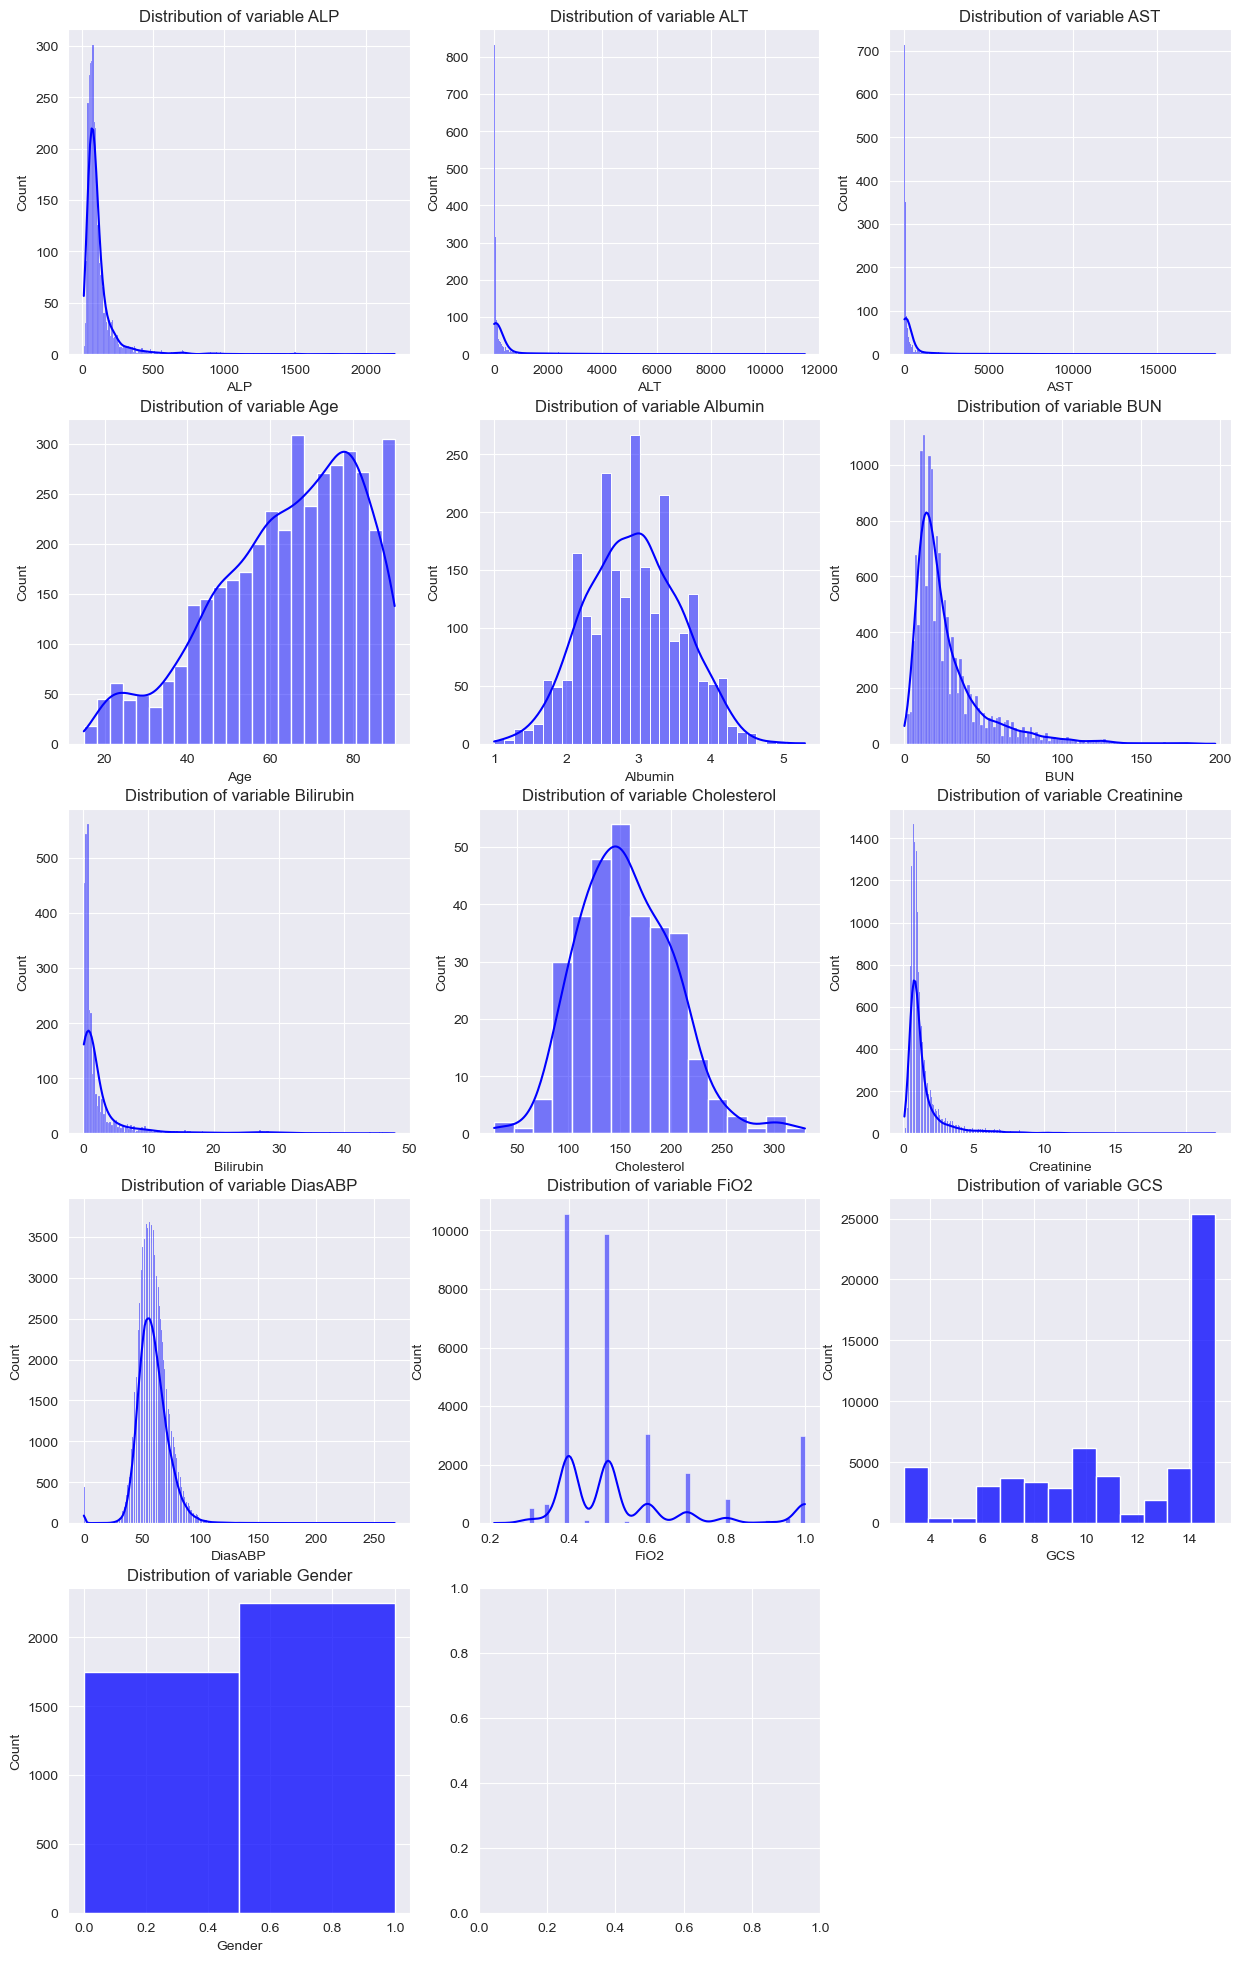

In [ ]:
static_columns = ["Age", "Gender", "Height", "ICUType", "Weight"]

# Plot each column's distribution
def plot_distributions(df, static_columns):
    # Columns to exclude from the visualization plot
    exclude_cols = ['time', 'recordid']

    # Set up the plotting grid
    cols_to_plot = [col for col in df.columns if col not in exclude_cols]
    num_cols = len(cols_to_plot)

    plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot((num_cols // 3) + 1, 3, i)
        if col in static_columns:  # Limit to one datapoint per recordid for static columns as values are present in multiple rows
            if col in ['Gender', 'ICUType']:  # Categorical and static variables
                bins = len(df[col].dropna().unique())  # Number of unique categories
                sns.histplot(df.groupby('recordid')[col].first(), bins=bins, color='blue')
            else:  # Other static and non-categorical variables
                sns.histplot(df.groupby('recordid')[col].first(), kde=True, color='blue')
        elif col in ['GCS', 'MechVent']:  # Categorical variables
            bins = len(df[col].dropna().unique())  # Number of unique categories
            sns.histplot(df[col], bins=bins, color='blue')
        else:
            sns.histplot(df[col], kde=True, color='blue')
        plt.title(f"Distribution of variable {col}")

    plt.tight_layout()
    plt.show()

plot_distributions(X_set_a, static_columns)

In [ ]:
X_set_a['MechVent'].value_counts()

In [ ]:
pd.set_option('display.max_columns', None)
X_set_a.describe()

In [ ]:
# Temporarily crop some outlier values to make the plot more readable
# Note: Ouliers will be removed in the preprocessing step, this is just for visualization
X_set_a_temp = X_set_a.copy()
X_set_a_temp.loc[X_set_a_temp['ALP'] >= 1000, 'ALP'] = np.nan
X_set_a_temp.loc[X_set_a_temp['ALT'] >= 1000, 'ALT'] = np.nan
X_set_a_temp.loc[X_set_a_temp['AST'] >= 1500, 'AST'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Bilirubin'] >= 12, 'Bilirubin'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Creatinine'] >= 10, 'Creatinine'] = np.nan
X_set_a_temp.loc[X_set_a_temp['DiasABP'] >= 150, 'DiasABP'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Glucose'] >= 600, 'Glucose'] = np.nan
X_set_a_temp.loc[X_set_a_temp['HR'] >= 200, 'HR'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Height'] >= 300, 'Height'] = np.nan
X_set_a_temp.loc[X_set_a_temp['K'] >= 10, 'K'] = np.nan
X_set_a_temp.loc[X_set_a_temp['MAP'] >= 200, 'MAP'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Mg'] >= 6, 'Mg'] = np.nan
X_set_a_temp.loc[X_set_a_temp['RespRate'] >= 60, 'RespRate'] = np.nan
X_set_a_temp.loc[X_set_a_temp['SaO2'] <= 85, 'SaO2'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Temp'] <= 30, 'Temp'] = np.nan
X_set_a_temp.loc[X_set_a_temp['TroponinT'] >= 6, 'TroponinT'] = np.nan
X_set_a_temp.loc[X_set_a_temp['Urine'] >= 1000, 'Urine'] = np.nan
X_set_a_temp.loc[X_set_a_temp['WBC'] >= 75, 'WBC'] = np.nan
X_set_a_temp.loc[X_set_a_temp['pH'] >= 15, 'pH'] = np.nan
X_set_a_temp.loc[X_set_a_temp['pH'] <= 5, 'pH'] = np.nan

plot_distributions(X_set_a_temp, static_columns)

In [ ]:
def plot_distributions_by_gender(df, static_columns):
    exclude_cols = ['time', 'recordid', 'Gender']
    cols_to_plot = [col for col in df.columns if col not in exclude_cols]
    num_cols = len(cols_to_plot)

    plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot((num_cols // 3) + 1, 3, i)
        if col in static_columns:  # Limit to one datapoint per recordid for static columns
            sns.histplot(data=df.groupby('recordid')[[col, 'Gender']].first(), x=col, hue='Gender', stat='probability', common_norm=False)
        else:
            sns.histplot(data=df, x=col, hue='Gender', stat='probability', common_norm=False)
        plt.title(f"Distribution of {col} by Gender")
        
    plt.tight_layout()
    plt.show()

plot_distributions_by_gender(X_set_a_temp, static_columns)

In [ ]:
def plot_distributions_by_age_bins(df, static_columns):
    # Create Age Bins (10-year intervals)
    df['age_bins'] = pd.cut(df['Age'], bins=np.arange(0, 100, 10))
    df['age_bins'] = df['age_bins'].astype(str)

    exclude_cols = ['time', 'recordid', 'Age', 'age_bins']
    cols_to_plot = [col for col in df.columns if col not in exclude_cols]
    num_cols = len(cols_to_plot)

    plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot(num_cols // 3 + 1, 3, i)
        if col in static_columns:  # Limit to one datapoint per recordid for static columns
            sns.histplot(data=df.groupby('recordid')[[col, 'age_bins']].first(), x=col, hue='age_bins', stat='probability', common_norm=False, element="step")
        else:
            sns.histplot(data=df, x=col, hue='age_bins', stat='probability', common_norm=False, element="step")
        plt.title(f"Distribution of {col} by Age Bins")

    plt.tight_layout()
    plt.show()

    df.drop(columns='age_bins', inplace=True)  # Drop the age_bins column after plotting

plot_distributions_by_age_bins(X_set_a_temp, static_columns)

In [ ]:
# Create a cholesterol plot for each age bin
# Create Age Bins (10-year intervals)
X_set_a['age_bins'] = pd.cut(X_set_a['Age'], bins=np.arange(0, 100, 10))
X_set_a['age_bins'] = X_set_a['age_bins'].astype(str)

plt.figure(figsize=(10, 6))
sns.boxplot(data=X_set_a, x='age_bins', y='Cholesterol', palette="coolwarm")
sns.pointplot(data=X_set_a, x='age_bins', y='Cholesterol', color='red', estimator=np.mean, ci=None, markers='o', linestyles='')
plt.title("Cholesterol Levels by Age Bins")
plt.xlabel("Age Bins")
plt.ylabel("Cholesterol")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Drop the age_bins column after plotting
X_set_a.drop(columns='age_bins', inplace=True)

In [ ]:
def plot_distributions_by_icu_type(df, static_columns):
    exclude_cols = ['time', 'recordid', 'ICUType']
    cols_to_plot = [col for col in df.columns if col not in exclude_cols]
    num_cols = len(cols_to_plot)

    plt.figure(figsize=(15, 5 * (num_cols // 3 + 1)))
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot(num_cols // 3 + 1, 3, i)
        if col in static_columns:
            sns.histplot(data=df.groupby('recordid')[[col, 'ICUType']].first(), x=col, hue='ICUType', stat='probability', common_norm=False, element="step", palette="coolwarm")
        else:
            sns.histplot(data=df, x=col, hue='ICUType', stat='probability', common_norm=False, element="step", palette="coolwarm")
        plt.title(f"Distribution of {col} by ICU Type")

    plt.tight_layout()
    plt.show()

plot_distributions_by_icu_type(X_set_a_temp, static_columns)

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_set_a, x='ICUType', y='Age', palette='viridis')
sns.pointplot(data=X_set_a, x='ICUType', y='Age', color='red', estimator=np.mean, ci=None, markers='o', linestyles='')
plt.title('Age Distribution by ICU Type')
plt.xlabel('ICU Type')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

#### Q1.3 Preprocess data for Machine Learning (2 Pts)

In [ ]:
# Functions for data cleaning
# Inspired by https://github.com/alistairewj/challenge2012/blob/master/prepare-data.ipynb
# and by feature descriptions in https://physionet.org/content/challenge-2012/1.0.0/

def delete_value(df, c, value=0):
    if c in df.columns:
        df[c] = df[c].replace(value, np.nan)
    return df

def replace_value(df, c, value=np.nan, below=None, above=None):
    idx = (df[c].notna()) & ((below is not None and df[c] < below) | (above is not None and df[c] > above))
    df.loc[idx, c] = df.loc[idx, c].apply(value) if callable(value) else value
    return df

def clean_data(df): 
    df = delete_value(df, 'DiasABP', -1)
    df = replace_value(df, 'DiasABP', value=np.nan, below=1)
    df = replace_value(df, 'DiasABP', value=np.nan, above=200)

    df = replace_value(df, 'FiO2', value=np.nan, below=0, above=1)

    df = replace_value(df, 'GCS', value=np.nan, below=3, above=15)

    df = replace_value(df, 'HCT', value=np.nan, below=0, above=100)

    df = replace_value(df, 'Height', value=np.nan, below=0)
    df = replace_value(df, 'Height', value=lambda x: x*100, below=10)
    df = replace_value(df, 'Height', value=lambda x: x*10, below=25)
    df = replace_value(df, 'Height', value=lambda x: x*2.54, below=100)  # Convert inches to cm
    df = replace_value(df, 'Height', value=lambda x: x*0.1, above=1000)
    df = replace_value(df, 'Height', value=lambda x: x*0.3937, above=250)  # Convert cm to inches

    df = replace_value(df, 'HR', value=np.nan, below=1)
    df = replace_value(df, 'HR', value=np.nan, above=299)

    df = replace_value(df, 'MAP', value=np.nan, below=1)

    df = replace_value(df, 'NIDiasABP', value=np.nan, below=1)

    df = replace_value(df, 'NIMAP', value=np.nan, below=1)
    
    df = replace_value(df, 'NISysABP', value=np.nan, below=1)

    df = replace_value(df, 'PaCO2', value=np.nan, below=1)
    df = replace_value(df, 'PaCO2', value=lambda x: x*10, below=10)

    df = replace_value(df, 'PaO2', value=np.nan, below=1)
    df = replace_value(df, 'PaO2', value=lambda x: x*10, below=20)

    # df = replace_value(df, 'pH', value=lambda x: x*10, below=0.8, above=0.65)
    # df = replace_value(df, 'pH', value=lambda x: x*0.1, below=80, above=65)
    # df = replace_value(df, 'pH', value=lambda x: x*0.01, below=800, above=650)
    df = replace_value(df, 'pH', value=np.nan, below=6.5)
    df = replace_value(df, 'pH', value=np.nan, above=8.0)

    df = replace_value(df, 'RespRate', value=np.nan, below=1)
    df = replace_value(df, 'SaO2', value=np.nan, below=1, above=100)

    df = replace_value(df, 'SysABP', value=np.nan, below=1)

    df = replace_value(df, 'Temp', value=lambda x: x*9/5+32, below=10, above=1)
    df = replace_value(df, 'Temp', value=lambda x: (x-32)*5/9, below=113, above=95)

    df = replace_value(df, 'Temp', value=np.nan, below=25)
    df = replace_value(df, 'Temp', value=np.nan, above=45)

    df = replace_value(df, 'WBC', value=np.nan, below=1)

    df = replace_value(df, 'Weight', value=np.nan, below=35)
    df = replace_value(df, 'Weight', value=np.nan, above=299)

    return df

In [53]:
X_set_a = clean_data(X_set_a)

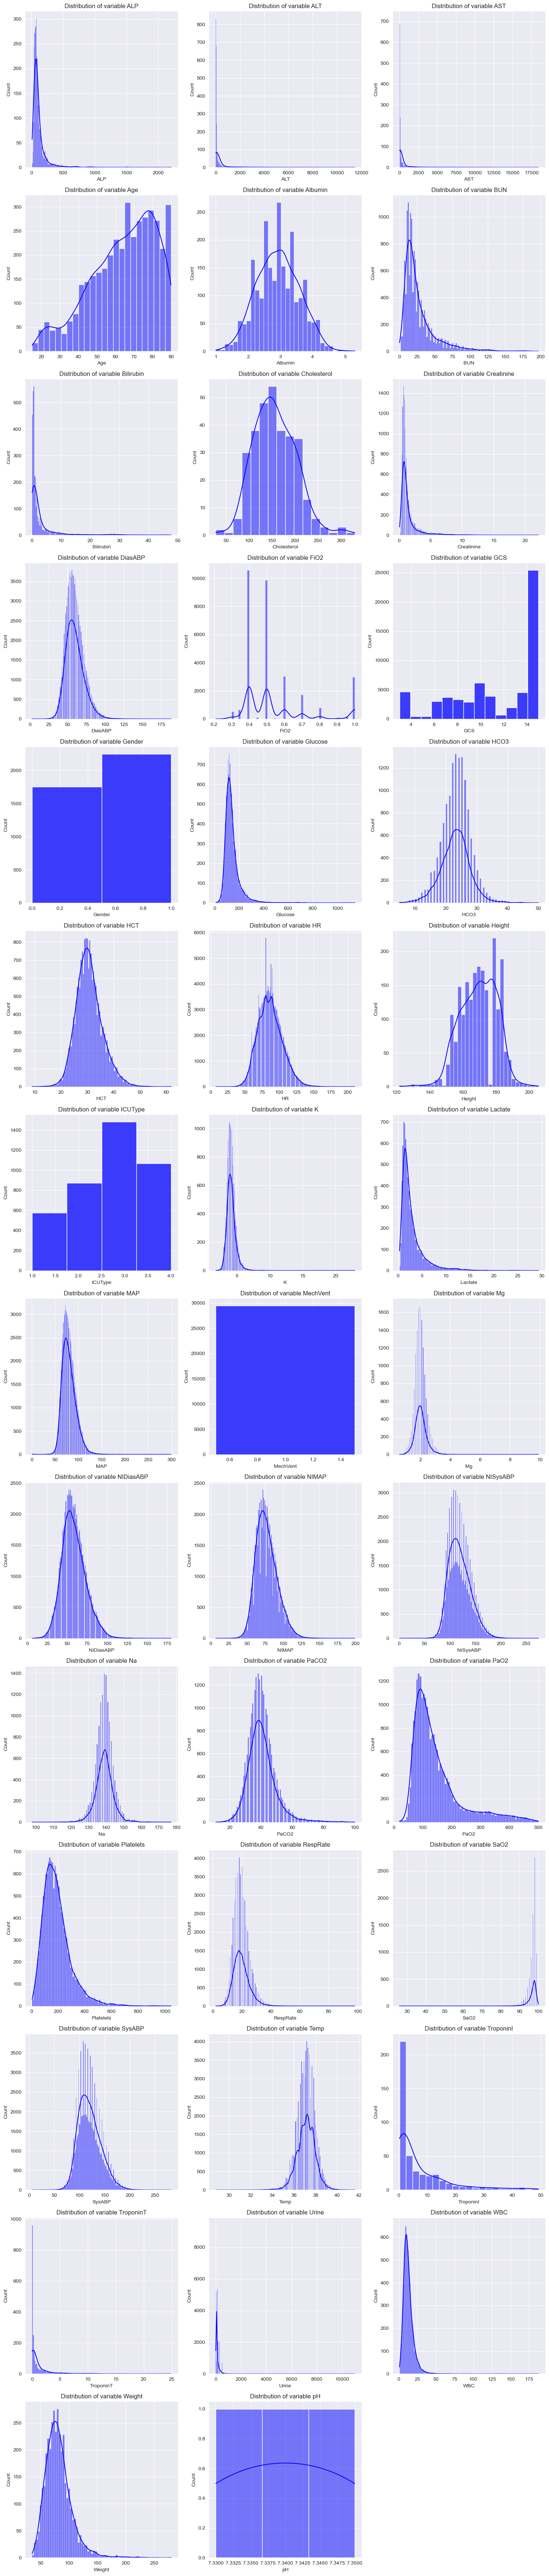

In [ ]:
# Plot each column's distribution after cleaning
plot_distributions(X_set_a, static_columns)

In [78]:
X_train = X_set_a
X_valid = X_set_b
X_test = X_set_b

y_train = np.array(Y_set_a.drop(columns=['recordid'])).ravel()
y_valid = np.array(Y_set_b.drop(columns=['recordid'])).ravel()
y_test = np.array(Y_set_c.drop(columns=['recordid'])).ravel()

In [64]:
def forward_fill(X_set_a, person_id_column):
    """
    Applies forward fill imputation within each person's data.
    This step fills missing values based on the previous known value.

    Parameters:
    X_set_a (pd.DataFrame): The input dataset with missing values.
    person_id_column (str): The name of the column that identifies individuals.

    Returns:
    pd.DataFrame: The dataset with missing values forward-filled.
    """
    # Forward fill within each person's data
    return X_set_a.groupby(person_id_column).apply(lambda group: group.ffill()).reset_index(drop=True)

def fill_with_median(X_set_a, medians):
    """
    Fills missing values with the provided medians for each column.

    Parameters:
    X_set_a (pd.DataFrame): The input dataset with missing values.
    medians (dict): A dictionary of column medians to use for filling missing values.

    Returns:
    pd.DataFrame: The dataset with missing values filled using medians.
    """
    return X_set_a.fillna(medians)

def get_column_medians(X_set_a):
    """
    Computes the medians for each column in the dataset.

    Parameters:
    X_set_a (pd.DataFrame): The input dataset.

    Returns:
    dict: A dictionary with the medians of each column.
    """
    return X_set_a.median()

def forward_fill_then_median(X_set_a, person_id_column, medians=None):
    """
    Applies forward fill imputation and replaces remaining NaNs with medians for each column.
    Optionally, if medians are provided, uses them to fill missing values.

    Parameters:
    X_set_a (pd.DataFrame): The input dataset with missing values.
    person_id_column (str): The name of the column that identifies individuals.
    medians (dict, optional): A dictionary with the medians for each column to fill missing values.

    Returns:
    pd.DataFrame: The dataset with missing values imputed.
    dict: The medians used for filling (if medians were provided, otherwise the medians are computed).
    """
    # Step 1: Forward fill within each person's data
    X_filled = forward_fill(X_set_a, person_id_column)

    # Step 2: If medians are provided, use them to fill missing values, otherwise compute medians
    if medians is not None:
        X_filled = fill_with_median(X_filled, medians)
    else:
        medians = get_column_medians(X_filled)
        X_filled = fill_with_median(X_filled, medians)

    return X_filled, medians

In [65]:
def aggregate_patient_data(X, person_id_column, categorical_columns=[]):
    """
    Aggregates the time-series data for each patient using three different methods:
    - Mean aggregation: Computes the mean of each feature per patient.
    - Max aggregation: Computes the max of each feature per patient.
    - Last-measured aggregation: Takes the last available value of each feature per patient.

    Parameters:
    X (pd.DataFrame): The input dataset containing time-series features.
    person_id_column (str): The name of the column that identifies individuals.

    Returns:
    tuple: (X_mean, X_max, X_last_measured) DataFrames where each row corresponds to a patient.
    """

    # Ensure person_id_column is treated separately
    grouped = X.groupby(person_id_column)

    # Mean aggregation
    X_mean = grouped.mean(numeric_only=True).reset_index()

    # Max aggregation
    X_max = grouped.max(numeric_only=True).reset_index()

    # Last-measured aggregation
    X_last_measured = grouped.last().reset_index()

    return X_mean, X_max, X_last_measured

from sklearn.preprocessing import RobustScaler

def prepare_data_for_ML_classifier(X_train, X_valid, X_test):
    """
    Prepares the data for machine learning classification by:
    - Dropping unnecessary columns
    - Forward filling missing values and replacing NaNs with column medians
    - Aggregating the data by mean, max, and last-measured values
    - Scaling the data using RobustScaler

    Parameters:
    X_train (pd.DataFrame): Training dataset
    X_valid (pd.DataFrame): Validation dataset
    X_test (pd.DataFrame): Test dataset

    Returns:
    tuple: Scaled datasets for training, validation, and test sets, each containing
           mean, max, and last-measured aggregated features.
    """

    # Step 1: Drop unnecessary columns ('time' and 'ICUType')
    X_train = X_train.drop(columns=["time", "ICUType"])
    X_valid = X_valid.drop(columns=["time", "ICUType"])
    X_test = X_test.drop(columns=["time", "ICUType"])

    # Step 2: Forward fill missing values within each person's data and replace remaining NaNs with column medians
    # 'train_medians' stores the medians calculated from the training data to ensure consistency during imputation
    X_train, train_medians = forward_fill_then_median(X_train, person_id_column="recordid")
    X_valid, _ = forward_fill_then_median(X_valid, person_id_column="recordid", medians=train_medians)
    X_test, _ = forward_fill_then_median(X_test, person_id_column="recordid", medians=train_medians)

    # Step 3: Aggregate the data for each patient by different methods (mean, max, last-measured)
    # This step is crucial as it reduces the time-series data to a fixed-size representation for each patient
    X_train_mean, X_train_max, X_train_last_measured = aggregate_patient_data(X_train, person_id_column="recordid")
    X_valid_mean, X_valid_max, X_valid_last_measured = aggregate_patient_data(X_valid, person_id_column="recordid")
    X_test_mean, X_test_max, X_test_last_measured = aggregate_patient_data(X_test, person_id_column="recordid")

    X_train_mean.drop(columns=["recordid"], inplace=True)
    X_train_max.drop(columns=["recordid"], inplace=True)
    X_train_last_measured.drop(columns=["recordid"], inplace=True)

    X_valid_mean.drop(columns=["recordid"], inplace=True)
    X_valid_max.drop(columns=["recordid"], inplace=True)
    X_valid_last_measured.drop(columns=["recordid"], inplace=True)

    X_test_mean.drop(columns=["recordid"], inplace=True)
    X_test_max.drop(columns=["recordid"], inplace=True)
    X_test_last_measured.drop(columns=["recordid"], inplace=True)

    # Step 4: Initialize the scaler (RobustScaler is used here to be robust to outliers)
    scaler = StandardScaler()

    # Step 5: Scale the aggregated data for each method (mean, max, last-measured)
    # Fit on the training data and transform the validation and test sets using the same scaler
    X_train_mean, X_valid_mean, X_test_mean = scale_data(X_train_mean, X_valid_mean, X_test_mean, scaler)
    X_train_max, X_valid_max, X_test_max = scale_data(X_train_max, X_valid_max, X_test_max, scaler)
    X_train_last_measured, X_valid_last_measured, X_test_last_measured = scale_data(X_train_last_measured, X_valid_last_measured, X_test_last_measured, scaler)

    # Step 6: Return the final scaled datasets for training, validation, and test sets
    return (X_train_mean, X_train_max, X_train_last_measured,
            X_valid_mean, X_valid_max, X_valid_last_measured,
            X_test_mean, X_test_max, X_test_last_measured)

def scale_data(X_train, X_valid, X_test, scaler):
    """
    Scales the training, validation, and test datasets using the provided scaler.

    Parameters:
    X_train (pd.DataFrame): The training dataset
    X_valid (pd.DataFrame): The validation dataset
    X_test (pd.DataFrame): The test dataset
    scaler (sklearn.preprocessing.RobustScaler): The scaler to use for transformation

    Returns:
    tuple: Scaled datasets for training, validation, and test sets
    """
    # Fit the scaler on the training data and transform it
    X_train_scaled = scaler.fit_transform(X_train)

    # Transform the validation and test data using the same scaler
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_valid_scaled, X_test_scaled

In [79]:
(X_train_mean, X_train_max, X_train_last_measured,
            X_valid_mean, X_valid_max, X_valid_last_measured,
            X_test_mean, X_test_max, X_test_last_measured) = prepare_data_for_ML_classifier(X_set_a, X_set_b, X_set_c)

/var/folders/zf/y1pcjkrd5r3_0x4pjdwt9rc00000gn/T/ipykernel_63579/651748209.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return X_set_a.groupby(person_id_column).apply(lambda group: group.ffill()).reset_index(drop=True)
/var/folders/zf/y1pcjkrd5r3_0x4pjdwt9rc00000gn/T/ipykernel_63579/651748209.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return X_set_a.groupby(person_id_column).apply(lambda g

Training and Evaluating LR Models: 100%|██████████| 3/3 [00:00<00:00, 48.40dataset/s]


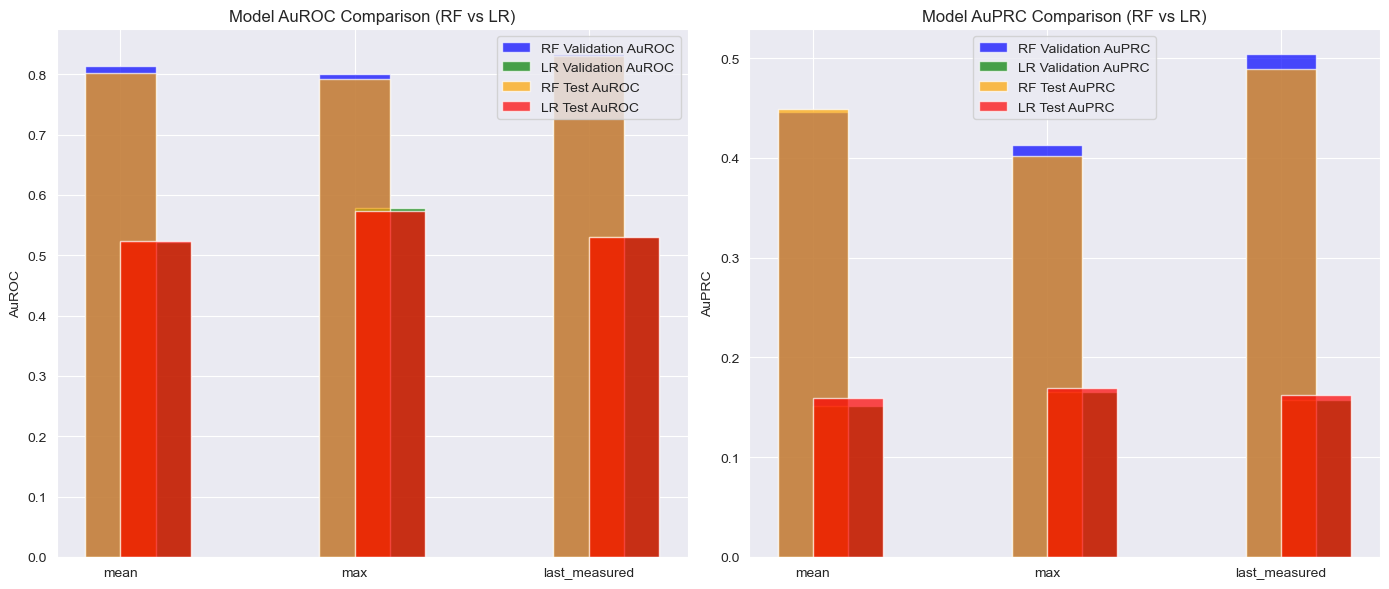

In [82]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm

def train_model(model_type, X_train, y_train):
    """
    Train the model on the given training data based on the specified model type.

    Parameters:
    model_type (str): The type of model to train ('rf' for RandomForest, 'lr' for Logistic Regression)
    X_train (pd.DataFrame): Features for training
    y_train (pd.Series or np.array): Target labels for training

    Returns:
    model: The trained model
    """
    if model_type == 'rf':
        model = RandomForestClassifier(random_state=42)
    elif model_type == 'lr':
        model = LogisticRegression(max_iter=1000, random_state=42)
    else:
        raise ValueError("Model type not supported. Use 'rf' or 'lr'.")

    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X, y):
    """
    Evaluate the model on a given dataset and return AuROC and AuPRC.

    Parameters:
    model: The trained model
    X (pd.DataFrame): Features for evaluation
    y (pd.Series or np.array): True labels for evaluation

    Returns:
    dict: A dictionary containing AuROC and AuPRC
    """
    y_pred_prob = model.predict_proba(X)[:, 1]  # Probability estimates for positive class
    auroc = roc_auc_score(y, y_pred_prob)
    auprc = average_precision_score(y, y_pred_prob)
    return {'auroc': auroc, 'auprc': auprc}

def train_and_evaluate_for_datasets(datasets, model_type, X_train_dict, X_valid_dict, X_test_dict, y_train, y_valid, y_test):
    """
    Train and evaluate models (Logistic Regression or Random Forest) for each dataset (mean, max, last_measured).

    Parameters:
    datasets (list): List of dataset names to iterate over ('mean', 'max', 'last_measured')
    model_type (str): The type of model to train ('rf' or 'lr')
    X_train_dict, X_valid_dict, X_test_dict (dict): Dictionaries containing feature datasets for each type
    y_train, y_valid, y_test (pd.Series or np.array): Target labels for training, validation, and testing

    Returns:
    dict: A dictionary containing performance results for each dataset
    """
    results = {}

    # Using tqdm for progress feedback
    for dataset in tqdm(datasets, desc=f"Training and Evaluating {model_type.upper()} Models", unit="dataset"):
        # Select the appropriate dataset for X
        X_train = X_train_dict[dataset]
        X_valid = X_valid_dict[dataset]
        X_test = X_test_dict[dataset]

        # Train the model
        model = train_model(model_type, X_train, y_train)

        # Evaluate the model on the validation set for tuning purposes
        valid_result = evaluate_model(model, X_valid, y_valid)

        # Evaluate the model on the test set for final evaluation
        test_result = evaluate_model(model, X_test, y_test)

        # Store the result
        results[dataset] = {
            'valid_auroc': valid_result['auroc'],
            'test_auroc': test_result['auroc'],
            'valid_auprc': valid_result['auprc'],
            'test_auprc': test_result['auprc']
        }

    return results

def plot_performance_comparison(results_rf, results_lr):
    """
    Plot the performance comparison for each dataset's validation and test set for both Random Forest and Logistic Regression.

    Parameters:
    results_rf (dict): A dictionary with performance metrics for Random Forest
    results_lr (dict): A dictionary with performance metrics for Logistic Regression
    """
    labels = list(results_rf.keys())

    # Prepare data for RandomForest and Logistic Regression
    rf_valid_auroc = [results_rf[dataset]['valid_auroc'] for dataset in labels]
    rf_test_auroc = [results_rf[dataset]['test_auroc'] for dataset in labels]
    lr_valid_auroc = [results_lr[dataset]['valid_auroc'] for dataset in labels]
    lr_test_auroc = [results_lr[dataset]['test_auroc'] for dataset in labels]

    rf_valid_auprc = [results_rf[dataset]['valid_auprc'] for dataset in labels]
    rf_test_auprc = [results_rf[dataset]['test_auprc'] for dataset in labels]
    lr_valid_auprc = [results_lr[dataset]['valid_auprc'] for dataset in labels]
    lr_test_auprc = [results_lr[dataset]['test_auprc'] for dataset in labels]

    x = range(len(labels))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot AuROC
    axes[0].bar(x, rf_valid_auroc, width=0.3, label='RF Validation AuROC', align='center', color='blue', alpha=0.7)
    axes[0].bar(x, lr_valid_auroc, width=0.3, label='LR Validation AuROC', align='edge', color='green', alpha=0.7)
    axes[0].bar(x, rf_test_auroc, width=0.3, label='RF Test AuROC', align='center', color='orange', alpha=0.7)
    axes[0].bar(x, lr_test_auroc, width=0.3, label='LR Test AuROC', align='edge', color='red', alpha=0.7)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].set_ylabel('AuROC')
    axes[0].set_title('Model AuROC Comparison (RF vs LR)')
    axes[0].legend()

    # Plot AuPRC
    axes[1].bar(x, rf_valid_auprc, width=0.3, label='RF Validation AuPRC', align='center', color='blue', alpha=0.7)
    axes[1].bar(x, lr_valid_auprc, width=0.3, label='LR Validation AuPRC', align='edge', color='green', alpha=0.7)
    axes[1].bar(x, rf_test_auprc, width=0.3, label='RF Test AuPRC', align='center', color='orange', alpha=0.7)
    axes[1].bar(x, lr_test_auprc, width=0.3, label='LR Test AuPRC', align='edge', color='red', alpha=0.7)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels)
    axes[1].set_ylabel('AuPRC')
    axes[1].set_title('Model AuPRC Comparison (RF vs LR)')
    axes[1].legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Dictionary of X datasets (mean, max, last_measured)
X_train_dict = {
    'mean': X_train_mean,
    'max': X_train_max,
    'last_measured': X_train_last_measured
}

X_valid_dict = {
    'mean': X_valid_mean,
    'max': X_valid_max,
    'last_measured': X_valid_last_measured
}

X_test_dict = {
    'mean': X_test_mean,
    'max': X_test_max,
    'last_measured': X_test_last_measured
}

# Train and evaluate both models (Random Forest and Logistic Regression)
datasets = ['mean', 'max', 'last_measured']

# Random Forest Results
results_rf = train_and_evaluate_for_datasets(datasets, 'rf', X_train_dict, X_valid_dict, X_test_dict, y_train, y_valid, y_test)

# Logistic Regression Results
results_lr = train_and_evaluate_for_datasets(datasets, 'lr', X_train_dict, X_valid_dict, X_test_dict, y_train, y_valid, y_test)

# Plot the performance comparison for both models
plot_performance_comparison(results_rf, results_lr)


In [83]:
results_rf

{'mean': {'valid_auroc': 0.8130324780852949,
  'test_auroc': 0.801951671234248,
  'valid_auprc': 0.44595593219409013,
  'test_auprc': 0.44884318022080727},
 'max': {'valid_auroc': 0.8011548310844085,
  'test_auroc': 0.7928147564165133,
  'valid_auprc': 0.41255561760487697,
  'test_auprc': 0.40212872088934914},
 'last_measured': {'valid_auroc': 0.8327582775206014,
  'test_auroc': 0.8294374992178799,
  'valid_auprc': 0.5037311316485976,
  'test_auprc': 0.48946336569310506}}

In [84]:
results_lr

{'mean': {'valid_auroc': 0.5212652664237172,
  'test_auroc': 0.5240800390434358,
  'valid_auprc': 0.1512841148577692,
  'test_auprc': 0.15921283873065684},
 'max': {'valid_auroc': 0.5781332077546867,
  'test_auroc': 0.5735728497953974,
  'valid_auprc': 0.16539791363315026,
  'test_auprc': 0.1691559892031074},
 'last_measured': {'valid_auroc': 0.5303740786795365,
  'test_auroc': 0.5308212886836605,
  'valid_auprc': 0.15689728113928095,
  'test_auprc': 0.16206239995531047}}